# Project 3
## Non-parametric methods 
<div class = "alert alert-success">
Since the non-parametric schemes presented in this topic can be used to solve a classification or
regression task, each group will choose a target variable (principally uni-dimensional unless the
dataset specifies otherwise) to address one of these two tasks (selected by the group). It is
suggested to approach this task using the k-nearest neighbors scheme, classification/regression
trees, multi-layer perceptron (considered an artificial neural network), and an ensemble scheme
such as Random Forest or Gradient Boosting.
In developing the following schemes, always use the same partition of observations associated
with the test set. This will allow for fair comparisons between different approaches.
Explain in detail (implementation is not necessary) what you could do if you did not have a test
partition and wanted to estimate the generalization capability while being "sufficiently confident"
that the chosen features are most suitable for the task.

</div>

we use classification (died or not at 1 year = target variable)



In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

### Load data 

In [38]:
X_train = pd.read_csv("minmax_scaled_x_train.csv") # already normalized
X_test = pd.read_csv("minmax_scaled_x_test.csv") # already normalized
y_train = pd.read_csv("Y_train.csv")
y_test = pd.read_csv("Y_test.csv")


As seen in the last lab, "Survival" which represents the duration the patient have survived after the heart attack and "Still-Alive" if the patient is still alive at the time of the study, represent too much information. A real-world model would just work based on the clinical parameters. As a consequence, we decided to remove them from the dataset. 

In [39]:
# get rid of survival and still-alive column in data 
X_train = X_train.drop(columns=['Survival', 'Still-Alive'])
X_test = X_test.drop(columns=['Survival', 'Still-Alive'])

In [40]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
X.head()

,Age-At-Heart-Attack,Pericardial-effusion,Fractional-Shortening,EPSS,LVDD,Wall-Motion-Score,Wall-Motion-Index
0,0.854876,0.0,0.238095,0.695652,0.282230,0.677419,0.601504
1,0.716993,0.0,0.833333,0.260870,0.236934,0.419355,0.526316
2,0.634263,1.0,0.425372,0.498555,0.548921,0.722590,0.475939
3,0.710926,0.0,0.389048,0.215909,0.620176,0.019677,0.146618
4,0.736608,0.0,0.469317,0.565324,0.917483,0.007061,0.392318


In [41]:
y.head()

,Alive-At1
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0


In [42]:
y_train = y_train.values.reshape(-1, 1).ravel() # to avoid errors
y_test = y_test.values.reshape(-1, 1).ravel() # to avoid errors

### Grid search and plot result functions

In [56]:
from sklearn.model_selection import GridSearchCV
from utils import analyze_train_test_performance  

# These are customized functions: should be in utils.py
def hyper_parameters_search(clf, X, y, param_grid, scorer = 'f1', cv=5):
    
    grid = GridSearchCV(clf, param_grid = param_grid, scoring = scorer, cv = cv)
    grid.fit(X, y)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))
    
    return grid

def plot_cv_scoring(grid, hyper_parameter, scorer = 'f1', plot_errors = False, log=False):
    
    scores = np.array(grid.cv_results_['mean_test_score'])
    std_scores = grid.cv_results_['std_test_score']
    params = grid.param_grid[hyper_parameter]
    
    if log:
        params = np.log10(params)
    if plot_errors:
        plt.errorbar(params,scores,yerr=std_scores, fmt='o-',ecolor='g')
    else:
        plt.plot(params,scores, 'o-')
    plt.xlabel(hyper_parameter,fontsize=14)
    plt.ylabel(scorer)
    plt.show()
    
# feature importance
def plot_importances(importances, feat_names):
    
    df_importances = pd.Series(importances, index=feat_names)
    
    plt.figure()
    df_importances.plot.bar()
    plt.ylabel("Feature Importance")
    plt.show()

### K-NN
<div class = "alert alert-success">

Explain the meaning of the hyperparameter k. How is the target value of a specific test
observation estimated when applying the k-NN scheme?
1) How can you find the most suitable value for the hyperparameter k for a set of
observations?
2) Discuss the relationship between generalization capability and the value of the
hyperparameter k.
3) Suppose a k-NN scheme has been used with a database where the features have not been
normalized. Indicate whether the performance would change if the design and
performance evaluation were done with normalized variables. Justify your response.
4) Explore various values of the hyperparameter k and reasonably indicate which k value you
would choose. Include in the project one or more graphs showing the evolution of at least
two different performance metrics (useful for the task to be solved) for each explored k
value. Considering this information, justify the choice of a single k value.
5) With the chosen k value, determine the values of 4 performance metrics to estimate the
performance on a test set independent of the one used in the design. Comment on the
results obtained.
</div>

K is the number of cluster used. The idea is to assign the class label that is most frequent among the k-nearest neighbors to the test observation. In other words, the target value for the test observation is the majority class among its k-nearest neighbors.

1) By computing metrics over different k values and use cross validation to see which one produces the best score. 

2) When k is small, the model becomes more sensitive to noise and local fluctuations in the training data. The decision boundaries are more flexible and may follow the training data closely. This can lead to overfitting, where the model captures the noise in the training set, resulting in poor generalization to new, unseen data. The model may be too complex and fail to capture the underlying patterns. On the other hand, when k is large, the model's decision boundaries become smoother and less sensitive to individual data points. The model tends to generalize better because it relies on a larger number of neighbors, leading to a more stable prediction. However, if k is too large, the model may oversimplify and miss important patterns in the data, resulting in underfitting.

3) k-NN relies on the calculation of distances between data points. If the features are on different scales, features with larger magnitudes may dominate the distance computations. This sensitivity to scale can result in misleading distance measurements and affect the overall performance of the k-NN algorithm. 

4, 5) During cross-validation, k=3 is the best classifier in terms of recall scoring whereas k=2 is the best in term of f1-score. Let's see the associated results on test set. k=3 performances on test set are ACC:88.24; SEN:100.00 and ESP:71.43 whereas they are ACC:94.12; SEN:100.00; ESP:85.71 with k=2. Knowing that are our classes are balanced, we can trust accuracy metric. Anyway, k=2 has better generalisation (better accuracy and specificity and equal sensivity)

best mean cross-validation score: 0.867
best parameters: {'n_neighbors': 1}


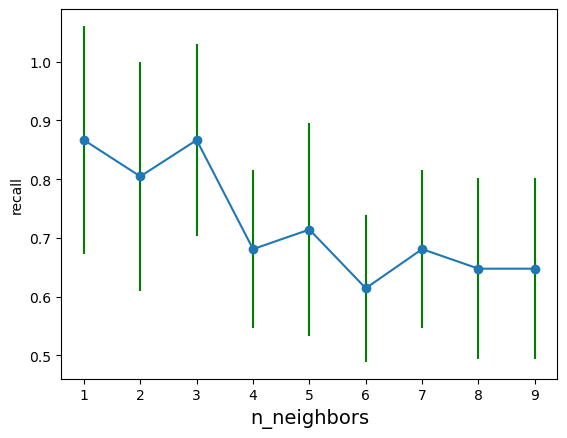

In [44]:
from sklearn.neighbors import KNeighborsClassifier

# Metric for the scoring
scorer = 'recall' 
param_grid = {'n_neighbors': range(1,10)}

estimator = KNeighborsClassifier()

# param_grid
grid_knn = hyper_parameters_search(estimator, X_train, y_train, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_knn,'n_neighbors', scorer, plot_errors=True)

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	100.00	94.12
SEN:	100.00	100.00
ESP:	100.00	85.71
PPV:	100.00	90.91
F1:	100.00	95.24


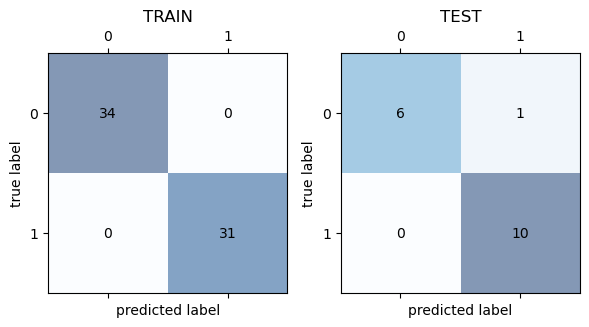

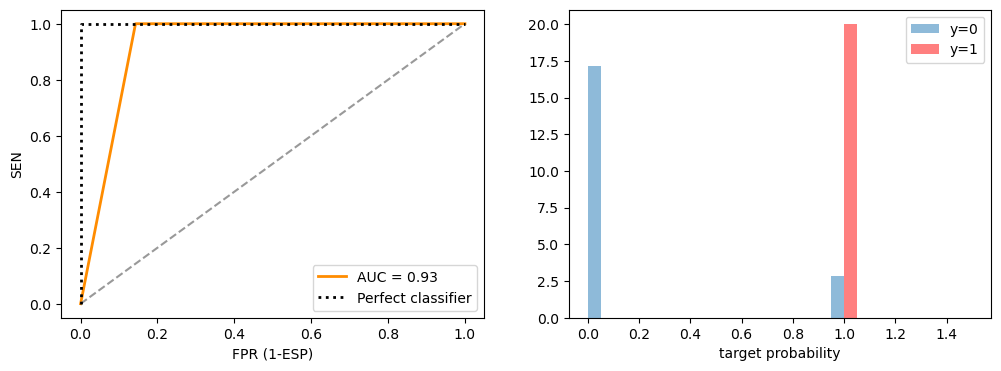

In [45]:
knn_model = grid_knn.best_estimator_
analyze_train_test_performance(knn_model, X_train, X_test, y_train, y_test) 

best mean cross-validation score: 0.811
best parameters: {'n_neighbors': 2}


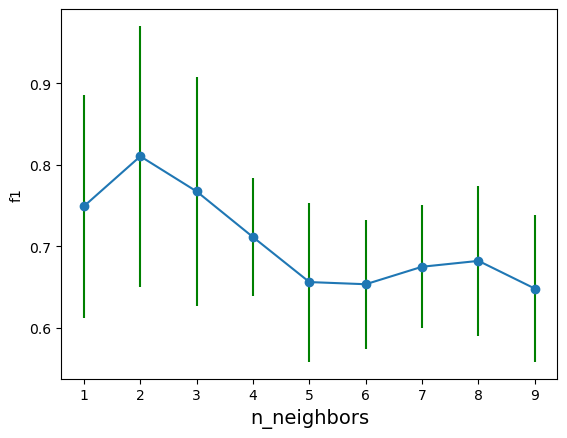

In [46]:
# Metric for the scoring
scorer = 'f1' 
param_grid = {'n_neighbors': range(1,10)}

estimator = KNeighborsClassifier()

# param_grid
grid_knn = hyper_parameters_search(estimator, X_train, y_train, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_knn,'n_neighbors', scorer, plot_errors=True)

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	93.85	94.12
SEN:	87.10	100.00
ESP:	100.00	85.71
PPV:	100.00	90.91
F1:	93.10	95.24


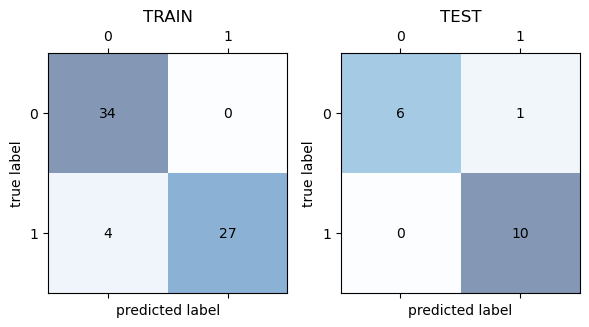

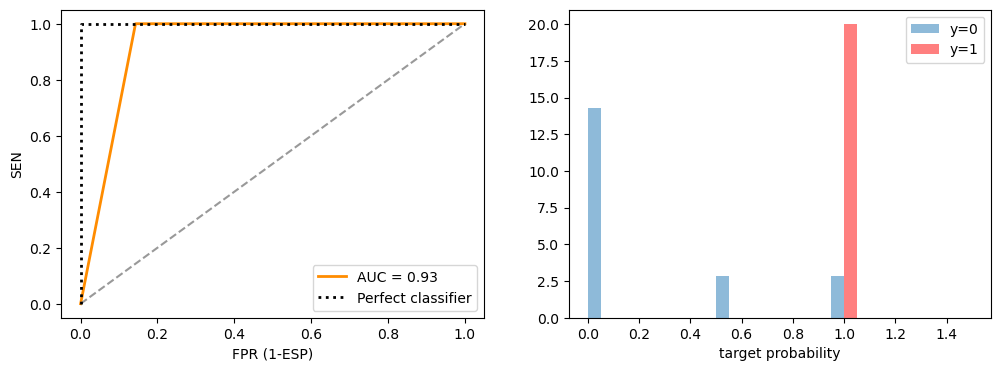

In [47]:
knn_model = grid_knn.best_estimator_
analyze_train_test_performance(knn_model, X_train, X_test, y_train, y_test) 

### Classification tree
<div class = "alert alert-success">

• Reasonably justify whether or not to normalize the features before applying this learning
scheme. \
• Considering the rule of thumb presented in the practical sessions of the subject*, evaluate
designs with different values associated with the hyperparameter "minimum number of
samples per node." Reasonably justify the explored values. \
• Reasonably indicate which value of the hyperparameter to choose. Include in the project
one or more graphs showing the evolution of at least two different performance metrics for
each explored value. Considering this information, justify the choice of the "minimum
number of samples per node." \
• Visualize the obtained tree. Draw conclusions about the importance of certain variables in
the solution provided by the tree. \
• With the chosen value, use 4 performance metrics to estimate the performance on a test set
independent of the one used in the design. Comment on the results obtained. \
</div>

1) We don't necesesarily have to normalize. The tree makes decisions based on the relative ordering of features rather than their absolute values. 

2) X is of length 65 so there is no interest in using bigger minimum number of samples per node. 

3) We do not get the same number of minimum number of samples required to split a node according to the scorer used for cross validation. Indeed, recall provides a much bigger number than f1-score (42 and 7 respectively). 

4) The variable present on the nodes are only Age-at-Heart-Attack and Wall-Motion-Index (a clinical parameter) when choosing 42. However, they are much more when choosing 7. We think that choosing a too huge value creates a too smooth model that will not be able to generalize. 

5) Indeed, the model with 7 as minimum number of samples for splitting better generalize: \
    model1 (min_samples_split=7):
        ACC:	88.24
        SEN:	80.00
        ESP:	100.00
        AUC:    0.9
        
    model2 (min_samples_split=42):
        ACC:	76.47
        SEN:	70.00
        ESP:	85.71
        AUC:    0.8
    

(65, 7)
best mean cross-validation score: 0.837
best parameters: {'min_samples_split': 7}


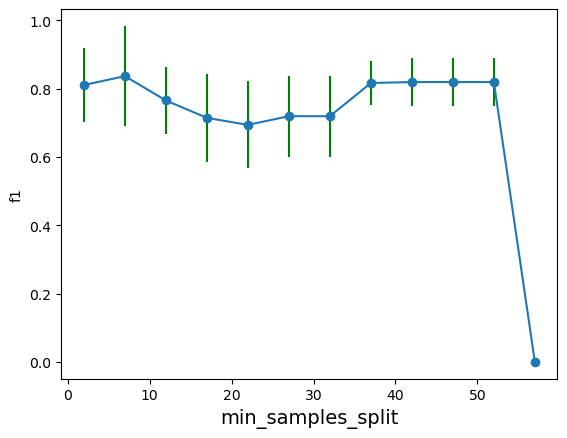

In [61]:
from sklearn.tree import DecisionTreeClassifier
print(X_train.shape)
# Decision trees
param_grid = {'min_samples_split': range(2, 60, 5)} # minimum number of samples required to split an internal node

scorer = 'f1'
estimator = DecisionTreeClassifier(random_state=0, criterion='gini') # we can the change the criterion to entropy 

#HYPER PARAMETER SEARCH
grid_dt = hyper_parameters_search(estimator, X_train, y_train, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_dt,'min_samples_split',scorer, plot_errors=True)
dt_model = grid_dt.best_estimator_

best mean cross-validation score: 1.000
best parameters: {'min_samples_split': 42}


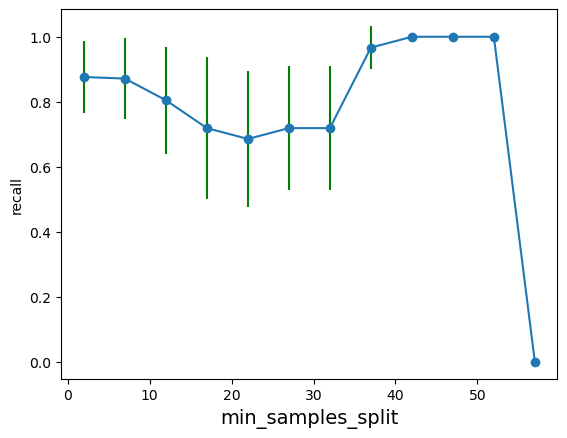

In [64]:
scorer = 'recall'

#HYPER PARAMETER SEARCH
grid_dt = hyper_parameters_search(estimator, X_train, y_train, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_dt,'min_samples_split',scorer, plot_errors=True)
dt_model2 = grid_dt.best_estimator_

Let's analyze the decision tree model with 7 as minimum number of samples for split. 

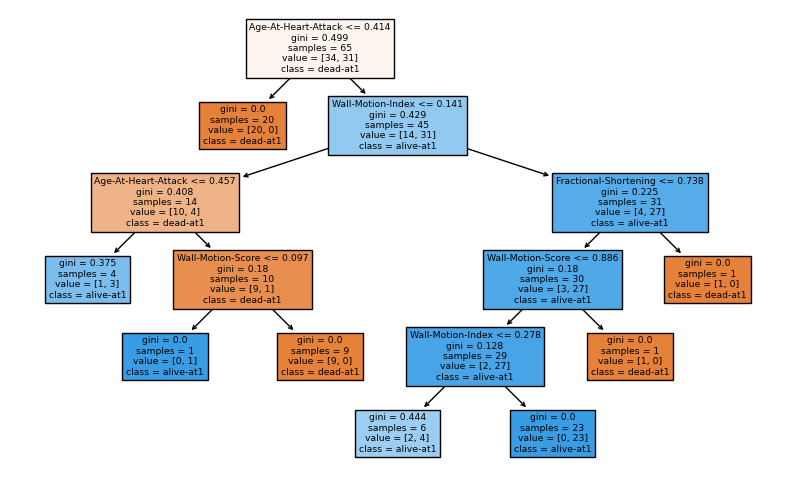

In [62]:
from sklearn.tree import plot_tree

# set plot dimensions
plt.figure(figsize=(10,6))

feature_names=X.columns # careful with what is X 

plot_tree(
    dt_model,
    feature_names=feature_names, 
    class_names=['dead-at1','alive-at1'], 
    filled=True
)
plt.title("Decision Tree - F1-score cross validation")
plt.show()

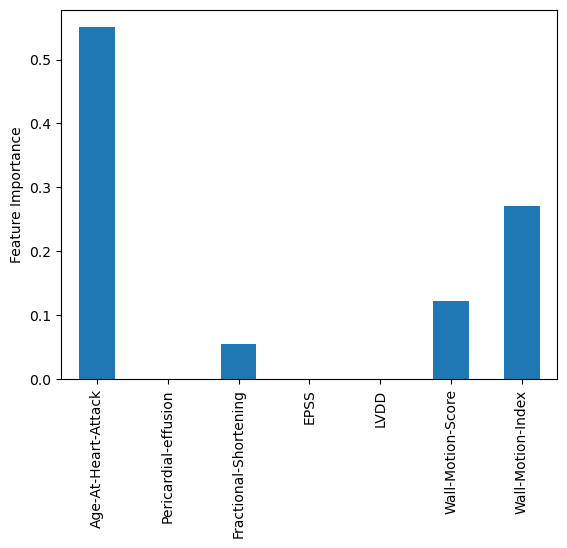

In [67]:
plot_importances(dt_model.feature_importances_, feature_names)

Let's analyse our model with the best number of samples to split a node according to the recall score in cross validation. 

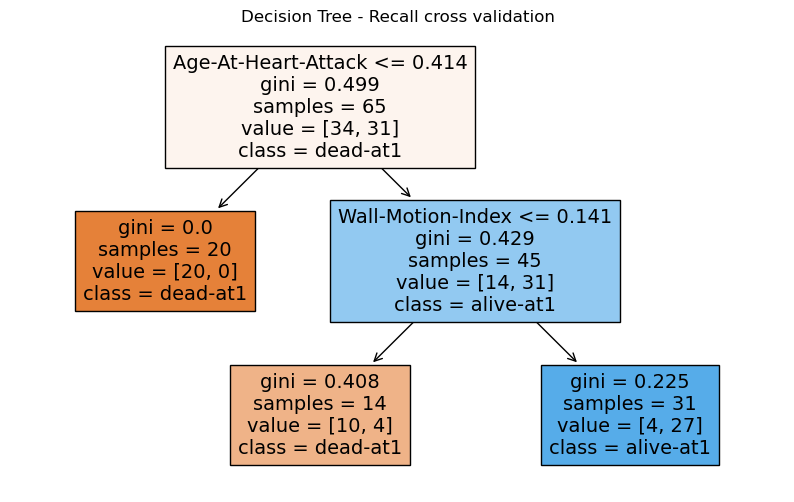

In [65]:
# set plot dimensions
plt.figure(figsize=(10,6))

feature_names=X.columns # careful with what is X 

plot_tree(
    dt_model2,
    feature_names=feature_names, 
    class_names=['dead-at1','alive-at1'], 
    filled=True
)
plt.title("Decision Tree - Recall cross validation")
plt.show()

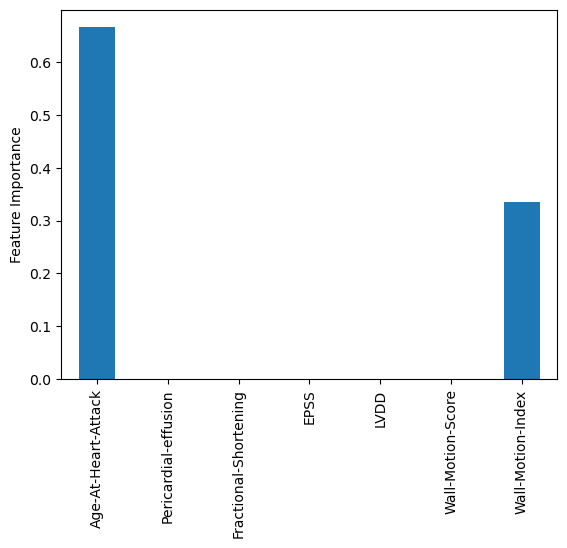

In [60]:
plot_importances(dt_model2.feature_importances_, feature_names)

Let's now compare the performances of the 2 models on the test set. 

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	95.38	88.24
SEN:	100.00	80.00
ESP:	91.18	100.00
PPV:	91.18	100.00
F1:	95.38	88.89


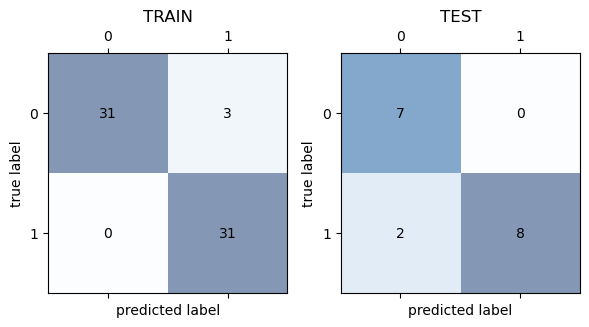

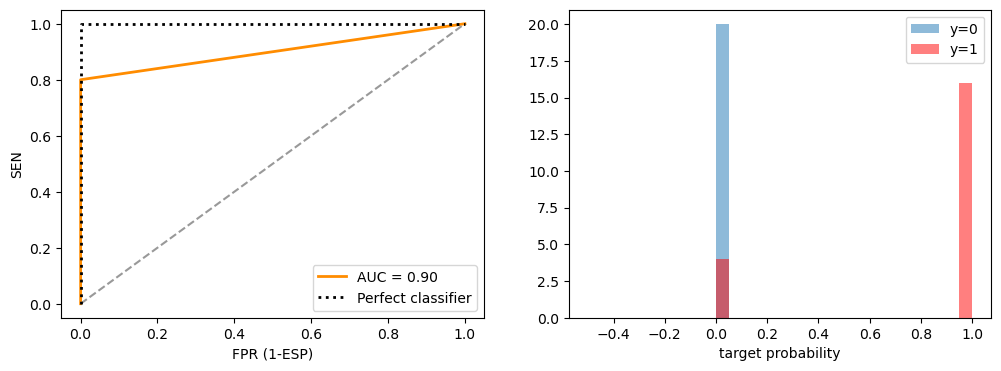

In [68]:
analyze_train_test_performance(dt_model, X_train, X_test, y_train, y_test) 

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	87.69	76.47
SEN:	87.10	70.00
ESP:	88.24	85.71
PPV:	87.10	87.50
F1:	87.10	77.78


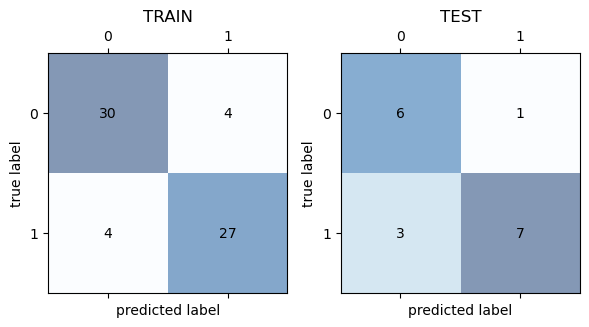

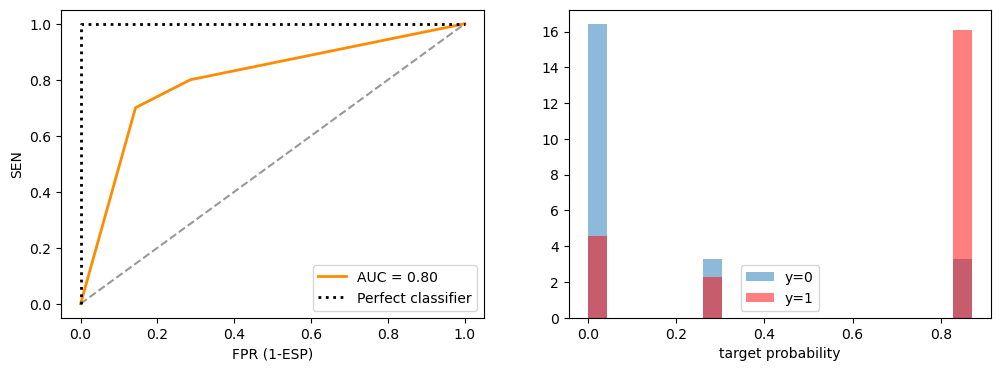

In [66]:
analyze_train_test_performance(dt_model2, X_train, X_test, y_train, y_test) 

### Multi-layer perceptron
<div class = "alert alert-success">

• In terms of underfitting and overfitting, reasonably justify which is more likely to occur if
a single hidden layer with one neuron is considered to solve the task. Design accordingly
and obtain the model's performance considering different performance metrics. 

• Explain if it is reasonable to approach the design of an MLP with a single hidden layer of
neurons. Explain, applied to your set of observations, what the statement "The MLP is a
universal approximator" refers to. 

• Discuss the need or lack thereof to normalize the features before training the model. 

• Train an MLP considering a different number of hidden neurons using a "batch" learning
scheme and considering sufficient epochs (or iterations). Monitor and represent the
evolution of the value of the most suitable performance metric for tackling your task and
stop the iterative learning process based on that performance metric value. What
architecture have you chosen? Justify your response. 

• Use the chosen architecture to evaluate the model's performance on the test set, obtaining
the values associated with the 4 previous performance metrics. Comment on the results
obtained.
</div>

1) A neural network with a single hidden layer and one neuron has very limited capacity to learn complex patterns in the data.  



### Single hidden layer perceptron 

best mean cross-validation score: 0.813
best parameters: {'alpha': 0.01, 'hidden_layer_sizes': 91}
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	93.85	76.47
SEN:	90.32	70.00
ESP:	97.06	85.71
PPV:	96.55	87.50
F1:	93.33	77.78


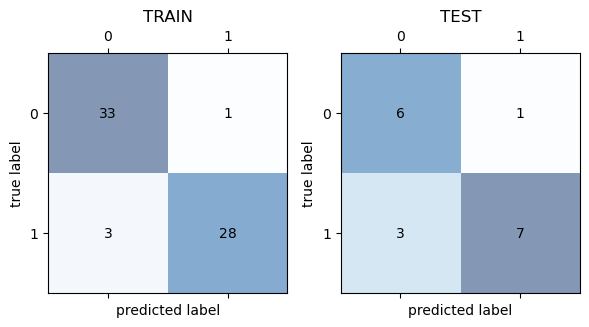

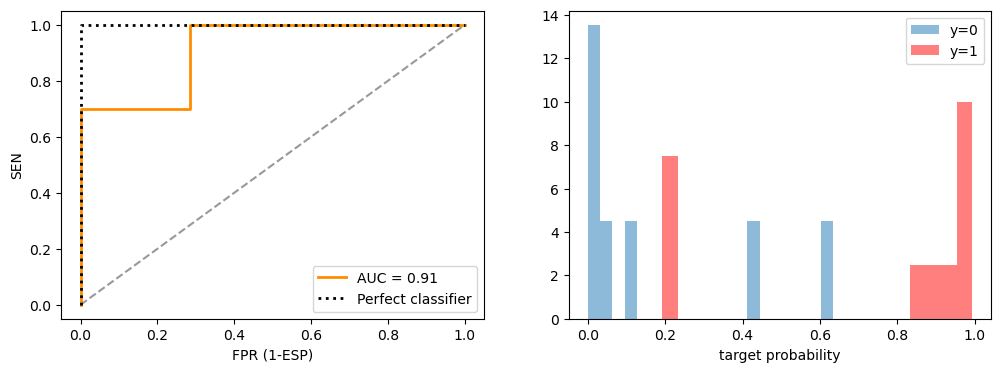

In [75]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

param_grid = {
    'alpha' : 10.0 ** -np.arange(2, 5), # regularization parameter
    'hidden_layer_sizes': np.arange(1, 100, 10), # number of hidden units
}
scorer = 'f1'
model = MLPClassifier(random_state=0, max_iter=1000, solver='adam')
grid_mlp = hyper_parameters_search(model, X_train, y_train, param_grid, scorer=scorer, cv=5)
mlp_model = grid_mlp.best_estimator_
analyze_train_test_performance(mlp_model, X_train, X_test, y_train, y_test) 

Accuracy, specificity and sensibility are 15-20% lower in test than training set. A lot of 1 labels are predicted as 0: our model is clearly under-fitting. 

2) Neural networks derive their power from the ability to learn hierarchical representations of features. With only one neuron, the network struggles to create diverse and informative representations of the eight features that we have. 

3) Data have to be normalized. Models optimized using gradient descent such as MLP, may converge faster when features are normalized. Normalization helps prevent large-range features from causing the optimization process to take longer when oscillating between values.

4) Model design: A maximum of 1000 iterations is set. When the loss or score is not improving by at least 1e-4 for 10 consecutive iterations, convergence is considered to be reached and training stops. We chose to use 100 hidden layers of 100 neurons each. Using more did not provide better results. Also, a 'batch' learning scheme has been implemented using a batch size of 4 to 64. The right regularization (L2), initial learning rate and batch size parameters have been found using a grid search scheme. The optimization is based on backpropagating f1 loss with Adam optimizer and gradually decreasing learning rate beginning at 1e-3. Adam is a recent optimizer that also use ultimate and penultimate gradients, smoothing the optimization process.  

best mean cross-validation score: 0.920
best parameters: {'alpha': 0.001, 'batch_size': 8, 'learning_rate_init': 0.001}
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	93.85	76.47
SEN:	90.32	70.00
ESP:	97.06	85.71
PPV:	96.55	87.50
F1:	93.33	77.78


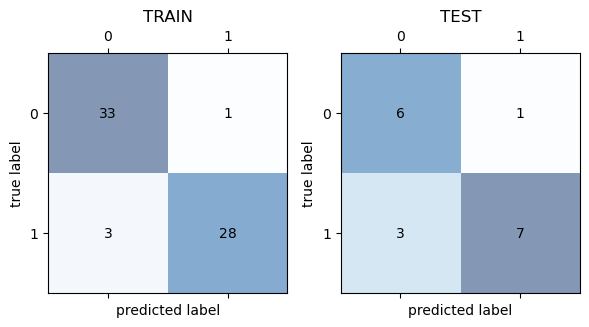

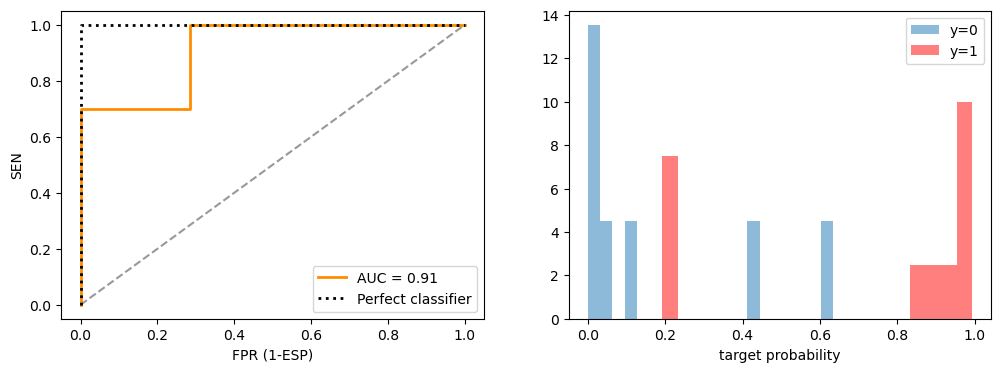

In [81]:
warnings.filterwarnings('ignore')

param_grid = {
    'alpha' : 10.0 ** -np.arange(2, 5), 
    'batch_size': [4, 8, 16, 32, 64],
    'learning_rate_init': 10.0 ** -np.arange(2, 5),
}

model = MLPClassifier(random_state=0, max_iter=1000, hidden_layer_sizes=(100, 100), solver='adam', learning_rate='invscaling')
scorer = 'f1'

#hyper_parameters_search()
grid_mlp2 = hyper_parameters_search(model, X_train, y_train, param_grid, scorer=scorer, cv=5)
mlp_model2 = grid_mlp.best_estimator_
analyze_train_test_performance(mlp_model2, X_train, X_test, y_train, y_test) 

Using a (100, 100) shape for hidden layers provides a better f1-score on cross validation (0.905 vs 0.813) but does not produce better performances on the test dataset. 

### Random forest or gradient boosting